In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import random
import os
import time
import sklearn
import umap
import seaborn
import tensorflow as tf
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPool1D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def multiclass_cnn(num_filters, filter_dim, dense):
    l2_lambda=0.01
    model = Sequential()
    model.add(Input(shape=(2048, 1)))
    model.add(Conv1D(filters = num_filters[0], kernel_size = filter_dim, activation = "relu", kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size = (2,)))
    model.add(Conv1D(filters = num_filters[1], kernel_size = filter_dim, activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size = (2,)))
    model.add(Flatten())
    model.add(Dense(dense, activation = 'relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(rate = 0.6))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ["accuracy", AUC(name="auc")])
    return model

def three_class_cnn(num_filters, filter_dim):
    model = Sequential()
    model.add(Input(shape=(2048, 1)))
    model.add(Conv1D(filters = num_filters[0], kernel_size = filter_dim, activation = "relu"))
    model.add(MaxPool1D(pool_size = (2,)))
    model.add(Conv1D(filters = num_filters[1], kernel_size = filter_dim, activation = "relu"))
    model.add(MaxPool1D(pool_size = (2,)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(3, activation = 'softmax'))
    model.summary()
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    return model

def get_fingerprints(smiles):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    fpgen = AllChem.GetMorganGenerator(radius=2)
    fingerprints = []
    for mol in mols:
        if mol:
            fingerprint = fpgen.GetFingerprint(mol)
            fingerprints.append(list(fingerprint))
    fingerprints_array = np.array(fingerprints)
    return fingerprints_array

def umap_model(neighbor, dist, data):
    model = umap.UMAP(n_neighbors = neighbor, n_components = 2, min_dist = dist, random_state = 12)
    twod_results = model.fit_transform(data)
    twod_df = pd.DataFrame(twod_results, columns = ['D1', 'D2'])
    return twod_df

In [2]:
#Part 1

all_info = pd.read_csv('../ROHS LAB/BRAF/p15056_chembl.csv', delimiter = ';')
all_info = all_info[all_info['Assay Variant Mutation'] == 'V600E']
#all_info = all_info.drop_duplicates(subset= 'Molecule ChEMBL ID', keep = 'first')
#Kd values from predetermined cut offs, Kd more accurate
train_hits = all_info[all_info['pChEMBL Value'] > 8]
#train_bads = all_info[all_info['pChEMBL Value'] < 6]
smiles = train_hits["Smiles"]

#loading in the data from the docking procedure
conf_1 = pd.read_csv('6p7g_revised_docked_scores.csv')
conf_1["Label"] = np.zeros(len(conf_1['name']))
conf_2 = pd.read_csv('4xv2_revised_docked_scores.csv')
conf_2["Label"] = np.ones(len(conf_2['name']))
conf_3 = pd.read_csv('4e26_revised_docked_scores.csv')
conf_3["Label"] = np.full(len(conf_3['name']), 2)
docked_molec = pd.concat([conf_1, conf_2, conf_3], ignore_index = True)
best_scores = docked_molec.loc[docked_molec.groupby("name")['score'].idxmin()]
best_scores = best_scores.reset_index(drop=True)
#HOW TO EXTRACT THE BEST LABELLED

chembl_master = pd.read_csv('all_smiles_df.csv')
chembl_master = chembl_master.drop_duplicates(subset="CHEMBL_ID", keep="first")
chembl_master = pd.merge(chembl_master, all_info[['Molecule ChEMBL ID', 'pChEMBL Value']], left_on = 'CHEMBL_ID', right_on='Molecule ChEMBL ID', how='inner')
chembl_master = chembl_master[chembl_master['pChEMBL Value'] >= 7]
# Merge best scores with the master SMILES data

#STUCK HERE
chembl_smiles = pd.merge(best_scores, chembl_master, left_on='name', right_on = 'CHEMBL_ID', how='inner')
# Extract relevant SMILES and retain in DataFrame
chembl_smiles = chembl_smiles[['name', 'score', 'CHEMBL_SMILES', 'Label']]
all_smiles = pd.concat([smiles, chembl_smiles['CHEMBL_SMILES']])
hit_fingerprints = get_fingerprints(all_smiles)

/opt/miniconda3/envs/lab-proj/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/lab-proj/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/miniconda3/envs/lab-proj/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/miniconda3/envs/lab-proj/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/miniconda3/envs/lab-proj/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for para

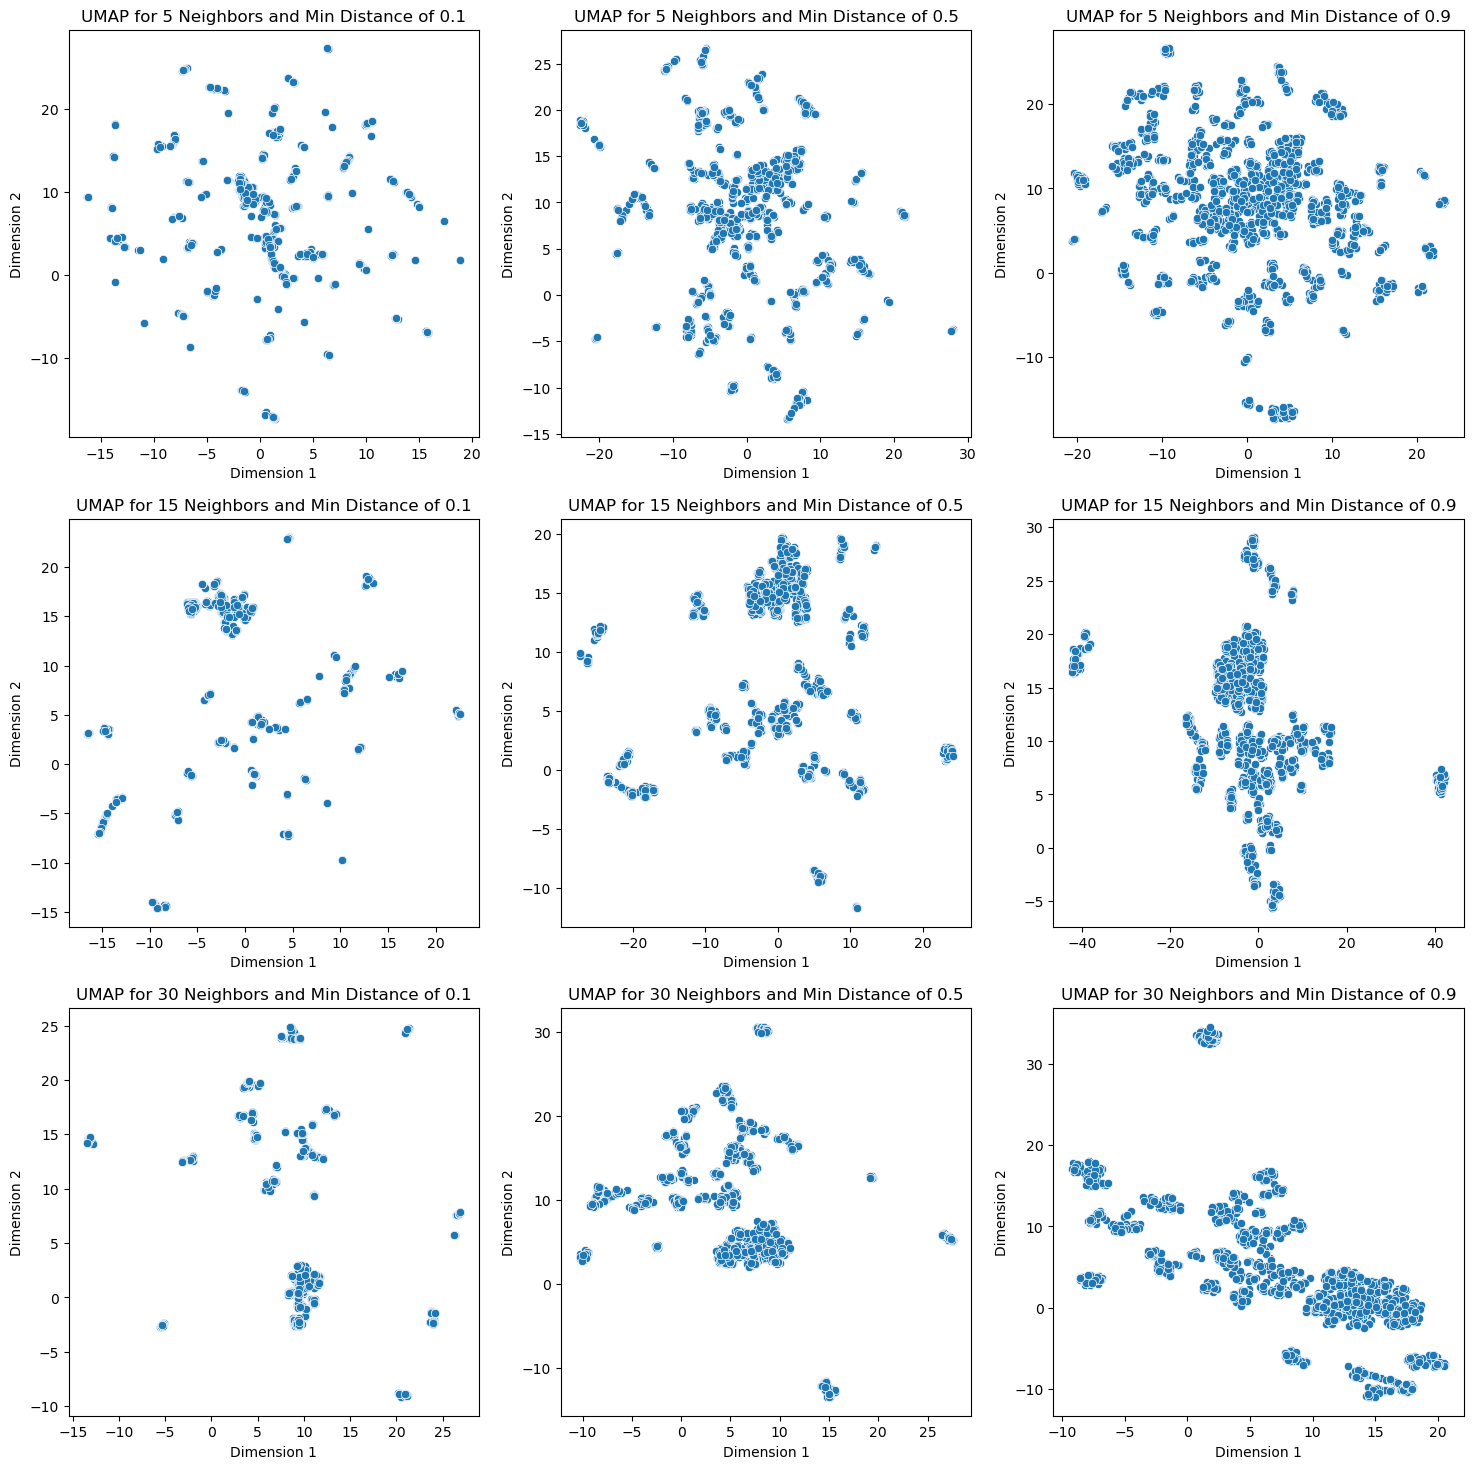

In [3]:
#Picking best UMAP
n_neighbors = [5, 15, 30]
min_dist = [0.1, 0.5, 0.9]

umap_results = []
umap_unlabelled = []
umap_labelled = []
for number in n_neighbors:
    for dist in min_dist:
        results = umap_model(number, dist, hit_fingerprints)
        umap_results.append(results)
        umap_unlabelled.append(results[:len(smiles)])
        umap_labelled.append(results[len(smiles):])

fig, axes = plt.subplots(3, 3, figsize = (18, 18))
axes = axes.flatten()
all_neighbors = [5, 5, 5, 15, 15, 15, 30, 30, 30]
all_dists = [0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9]
for i, (model, neigh, distance) in enumerate(zip(umap_results, all_neighbors, all_dists)):
    seaborn.scatterplot(data = model, x='D1', y='D2', ax = axes[i])
    axes[i].set_title(f'UMAP for {neigh} Neighbors and Min Distance of {distance}')
    axes[i].set_xlabel('Dimension 1')
    axes[i].set_ylabel('Dimension 2')
plt.show()

In [4]:
#Picking best UMAP to do KMeans clustering based off silhouette score
for i, (result, umap_label) in enumerate(zip(umap_results, umap_labelled)):
    all_labels = KMeans(n_clusters=3, random_state=42).fit_predict(result)
    labelled_labels = all_labels[len(smiles):]
    unique_labels = np.unique(labelled_labels)
    if len(unique_labels) < 2:
        score = 0
    else: 
        score = silhouette_score(umap_label, labelled_labels)
    overall = silhouette_score(result, all_labels)
    print(f"UMAP {i+1} Silhouette Score: {score} and Overall Score: {overall}")

UMAP 1 Silhouette Score: 0.735120952129364 and Overall Score: 0.31023117899894714
UMAP 2 Silhouette Score: 0.6002256274223328 and Overall Score: 0.33318591117858887
UMAP 3 Silhouette Score: 0.8646084070205688 and Overall Score: 0.34980136156082153
UMAP 4 Silhouette Score: 0.8156116008758545 and Overall Score: 0.5444688200950623
UMAP 5 Silhouette Score: 0.832220196723938 and Overall Score: 0.45798298716545105
UMAP 6 Silhouette Score: 0.9131022691726685 and Overall Score: 0.4027911126613617
UMAP 7 Silhouette Score: 0.6952430605888367 and Overall Score: 0.4563746750354767
UMAP 8 Silhouette Score: 0 and Overall Score: 0.44592615962028503
UMAP 9 Silhouette Score: 0.9427693486213684 and Overall Score: 0.5079631805419922


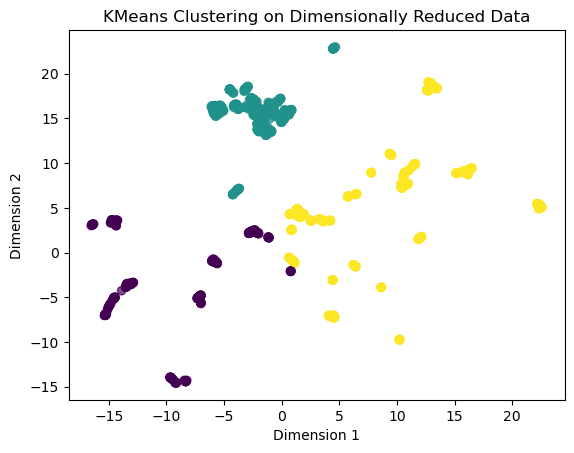

300 507 503


In [8]:
#Display best KMeans group
kmeans = KMeans(n_clusters = 3, random_state = 14)
umap_result = umap_results[3][['D1', 'D2']].values
clusters = kmeans.fit_predict(umap_result)
hits_labels = clusters
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, alpha=0.7)
plt.title("KMeans Clustering on Dimensionally Reduced Data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

print(len(all_smiles[hits_labels == 0]), len(all_smiles[hits_labels == 1]), len(all_smiles[hits_labels == 2]))


In [6]:
cluster_df = pd.DataFrame({
    'Original_Label': chembl_smiles['Label'], 
    'Cluster': labelled_labels                  
})

label_distribution = cluster_df.groupby('Cluster')['Original_Label'].value_counts()
print(label_distribution)
print(chembl_smiles['Label'].value_counts())


Cluster  Original_Label
0        0.0               23
1        0.0               40
         1.0                5
2        0.0               37
         1.0                2
Name: count, dtype: int64
Label
0.0    100
1.0      7
Name: count, dtype: int64


In [20]:
#labelling the train_bads
train_bads = all_info[all_info['pChEMBL Value'] < 6]
train_bads = train_bads['Smiles']
print(len(train_bads))
#Upsampling the smaller groups 
train_hits_two = resample(all_smiles[hits_labels == 2], replace=True, n_samples=len(train_bads), random_state=0)
train_hits_one = resample(all_smiles[hits_labels == 1], replace=True, n_samples=len(train_bads), random_state=0)
train_hits_zero = resample(all_smiles[hits_labels == 0], replace=True, n_samples=len(train_bads), random_state=0)

print(len(train_bads), len(train_hits_zero), len(train_hits_one), len(train_hits_two))

'''
chembl_smiles = [chembl_master['CHEMBL_SMILES'] if chembl_master['CHEMBL_ID'] == best_scores['name']]
'''
#Getting all fingerprints and all labels in one long DF
zeros_label = np.zeros(len(train_bads))
ones_label = np.ones(len(train_hits_zero))
twos_label = np.full(len(train_hits_one), 2)
threes_label = np.full(len(train_hits_two), 3)

combined_smiles = np.concatenate((train_bads, train_hits_zero, train_hits_one, train_hits_two))
labels = np.hstack((zeros_label, ones_label, twos_label, threes_label))
fingerprints = get_fingerprints(combined_smiles)
print(len(fingerprints), len(labels))

print("Sample SMILES:", combined_smiles[:5])
print("Sample Labels:", labels[:5])
print("Sample Fingerprints:", fingerprints[:5])


581
581 581 581 581
2324 2324
Sample SMILES: ['O=C(Nc1cccc(Oc2cccc3[nH]c(=O)[nH]c23)c1)c1ccc2sccc2c1'
 'CSc1csc2cc(-c3nc(-c4ccc(OCCN(C)C)cc4)[nH]c3-c3ccncc3)ccc12'
 'O=C(c1cc(-c2ccc3c(c2)Cc2cn[nH]c2-3)c(-c2ccncc2)o1)N1CCOCC1'
 'CN1CCN(C(=O)c2cc(-c3ccc4c(c3)Cc3cn[nH]c3-4)c(-c3ccncc3)o2)CC1'
 'Cc1cnc(Nc2ccc(OCCN3CCCC3)cc2)nc1Nc1cccc(S(=O)(=O)NC(C)(C)C)c1']
Sample Labels: [0. 0. 0. 0. 0.]
Sample Fingerprints: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
x_train, x_test, y_train, y_test = train_test_split(fingerprints, labels, test_size = 0.2, random_state= 13)
y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)
x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 2046, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1023, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1021, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 510, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     2,088,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,114,084 (8.06 MB)

 Trainable params: 2,114,084 (8.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4801 - auc: 0.7407 - loss: 1.2797 - val_accuracy: 0.8108 - val_auc: 0.9342 - val_loss: 0.8694
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7130 - auc: 0.9050 - loss: 0.8401 - val_accuracy: 0.8409 - val_auc: 0.9544 - val_loss: 0.5972
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7641 - auc: 0.9328 - loss: 0.6723 - val_accuracy: 0.8688 - val_auc: 0.9674 - val_loss: 0.4873
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7865 - auc: 0.9529 - loss: 0.5719 - val_accuracy: 0.8860 - val_auc: 0.9751 - val_loss: 0.4036
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8271 - auc: 0.9571 - loss: 0.5299 - val_accuracy: 0.8925 - val_auc: 0.9781 - val_loss: 0.3733
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8282 - auc: 0.9648 - loss: 0.4839 - val_accuracy: 0.8989 - val_auc: 0.9817 - val_loss: 0.3339
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/

Text(0.5, 1.0, 'Initial CNN Results')

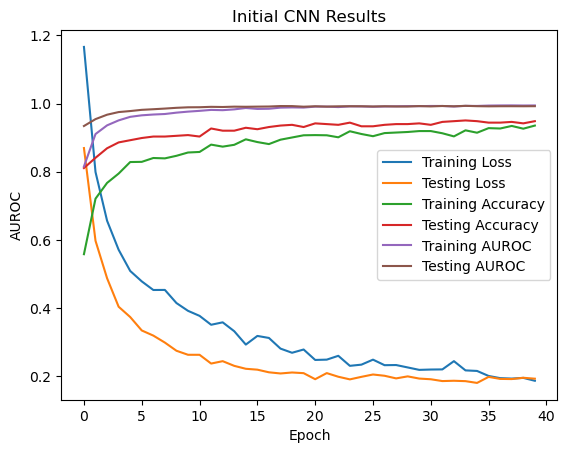

In [22]:
#Part 2
model = Sequential()
model.add(Input(shape=(2048, 1)))
model.add(Conv1D(filters = 64, kernel_size = (3,), activation = "relu", kernel_regularizer=l2(0.01)))
model.add(MaxPool1D(pool_size = (2,)))
model.add(Conv1D(filters = 128, kernel_size = (3,), activation = "relu"))
model.add(MaxPool1D(pool_size = (2,)))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(rate = 0.6))
model.add(Dense(4, activation = 'softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy", AUC(name="auc")])
history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data = (x_test, y_test))
print(history.history['val_accuracy'][-1])
print(history.history['val_loss'][-1])
print(history.history['val_auc'][-1])
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Testing Loss")
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Testing Accuracy")
plt.plot(history.history['auc'], label = "Training AUROC")
plt.plot(history.history['val_auc'], label = "Testing AUROC")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title('Initial CNN Results')

In [23]:
#loading in the data from the docking procedure
zinc = pd.read_csv('docking_scores.csv')
zinc_scores = zinc.loc[zinc.groupby("ZINC_ID")['Binding Affinity (kcal/mol)'].idxmin()]
zinc_scores = zinc_scores.reset_index(drop=True)

zinc_master = pd.read_csv('dbap-substances.csv')
zinc_master = zinc_master.drop_duplicates(subset="zinc_id", keep="first")
zinc_master = pd.merge(zinc_scores, zinc_master[['zinc_id', 'smiles']], left_on = 'ZINC_ID', right_on='zinc_id', how='inner')
# Merge best scores with the master SMILES data
print(zinc_master)
zinc_master = zinc_master[['ZINC_ID', 'Binding Affinity (kcal/mol)', 'smiles']]
zinc_smiles = zinc_master['smiles']
zinc_fingerprints = get_fingerprints(zinc_smiles)

prediction = model.predict(zinc_fingerprints)
print(prediction)

              ZINC_ID  Binding Affinity (kcal/mol)           zinc_id  \
0    ZINC000000000023                         -6.9  ZINC000000000023   
1    ZINC000000000038                         -7.1  ZINC000000000038   
2    ZINC000000000053                         -6.9  ZINC000000000053   
3    ZINC000000000061                         -7.2  ZINC000000000061   
4    ZINC000000000083                         -4.8  ZINC000000000083   
..                ...                          ...               ...   
594  ZINC000000608266                         -9.8  ZINC000000608266   
595  ZINC000000608382                        -10.0  ZINC000000608382   
596  ZINC000000621853                         -7.4  ZINC000000621853   
597  ZINC000000621893                         -7.5  ZINC000000621893   
598  ZINC000000622123                         -7.0  ZINC000000622123   

                                                smiles  
0                        C=CCc1ccccc1OC[C@H](O)CNC(C)C  
1                    

In [34]:
matching_rows = []

for i, probs in enumerate(prediction):  
    most_probable_class = np.argmax(probs)
    if most_probable_class == 1:
        row = zinc_master.iloc[i].copy()
        row['Class_0_Prob'] = probs[0]
        row['Class_1_Prob'] = probs[1]
        row['Class_2_Prob'] = probs[2]
        row['Class_3_Prob'] = probs[3]
        matching_rows.append(row)

# Create a DataFrame with the results
zinc_df = pd.DataFrame(matching_rows)

# Display the DataFrame
print(zinc_df)

zinc_df.to_csv('output.csv')


              ZINC_ID  Binding Affinity (kcal/mol)  \
4    ZINC000000000083                         -4.8   
34   ZINC000000000373                         -6.2   
74   ZINC000000000724                         -7.7   
88   ZINC000000000856                         -8.5   
97   ZINC000000000949                         -6.7   
122  ZINC000000001283                         -9.0   
147  ZINC000000001547                         -9.4   
163  ZINC000000001695                         -6.1   
214  ZINC000000002235                         -5.6   
232  ZINC000000004028                         -8.5   
251  ZINC000000005151                         -8.2   
264  ZINC000000006251                         -7.8   
278  ZINC000000007782                         -7.7   
279  ZINC000000008492                         -6.7   
324  ZINC000000020252                         -8.2   
335  ZINC000000035804                         -7.7   
347  ZINC000000056399                         -6.6   
382  ZINC000000057319       

In [ ]:
#USED TO FIND THE RIGHT VARIABLES FOR CNN

batch = [16, 32, 64]
filter_shape = [(3,), (5,)]
filter_num = [(32, 64), (64, 128)]
denses = [32, 64, 128]
accuracy_scores = []
auroc_scores = []
loss_scores = []
fig, axes = plt.subplots(6, 6, figsize = (18, 18))
axes = axes.flatten()
for b_idx, batch_size in enumerate(batch):
    for f_idx, filter_dim in enumerate(filter_shape):
        for n_idx, num_filters in enumerate(filter_num):
            for idx, dense in enumerate(denses):
                tf.keras.backend.clear_session()
                multiclass_cnn(num_filters, filter_dim, dense)
                history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, validation_data = (x_test, y_test))
                pred = model.predict(x_train)
                accuracy_scores.append(history.history['val_accuracy'][-1])
                loss_scores.append(history.history['val_loss'][-1])
                auroc_scores.append(history.history['val_auc'][-1])
                subplot_idx = b_idx*12 + f_idx*6 + n_idx*3 + idx
                axes[subplot_idx].plot(history.history['accuracy'], label = "Training Accuracy")
                axes[subplot_idx].plot(history.history['val_accuracy'], label = "Testing Accuracy")
                axes[subplot_idx].plot(history.history['auc'], label = "Training AUROC")
                axes[subplot_idx].plot(history.history['val_auc'], label = "Testing AUROC")
                axes[subplot_idx].plot(history.history['loss'], label = "Training Loss")
                axes[subplot_idx].plot(history.history['val_loss'], label = "Testing Loss")
                axes[subplot_idx].legend(fontsize=8)
                axes[subplot_idx].set_xlabel("Epoch", fontsize=10)
                axes[subplot_idx].set_ylabel("Metrics", fontsize=10)
                axes[subplot_idx].set_title(f'{batch_size} Batches, Filter Size {filter_dim}, {num_filters} Filters')

plt.figure()
configurations = []
for batch_size in batch:
    for filter_dim in filter_shape:
        for num_filters in filter_num:
            for dense in denses:
                configurations.append(f'Batch: {batch_size}, Filter: {filter_dim}, Num Filters: {num_filters}, Dense neurons {dense}')

plt.bar(range(len(configurations)), accuracy_scores)
plt.xticks(range(len(configurations)), configurations, rotation = 90, fontsize = 7)
plt.xlabel("Configurations")
plt.ylabel("Validation Accuracy")
plt.ylim((0.8, 1.0))
plt.title("Bar Plot Of Each Model's Accuracy")
plt.show()

plt.bar(range(len(configurations)), auroc_scores)
plt.xticks(range(len(configurations)), configurations, rotation = 90, fontsize = 7)
plt.xlabel("Configurations")
plt.ylabel("Validation AUROC")
plt.ylim((0.8, 1.0))
plt.title("Bar Plot Of Each Model's AUROC")
plt.show()

plt.bar(range(len(configurations)), loss_scores)
plt.xticks(range(len(configurations)), configurations, rotation = 90, fontsize = 7)
plt.xlabel("Configurations")
plt.ylabel("Validation LOSS")
plt.title("Bar Plot Of Each Model's LOSS")
plt.show()